# <center>Фаза1. Неделя1. Среда</center>
# <center>A/B тесты</center>

## __Сегодня__

1. Что же такое A/B тесты
2. Важные моменты при проведении A/B тестов
3. Достоинства и недостатки A/B тестов

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st         # модуль статистики из scipy (распределения, тесты и пр.)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings                  # модуль для управления предупреждениями
warnings.filterwarnings('ignore')  # отключаем предупреждения, чтобы не мешали выводу
from scipy.stats import ttest_ind # импорт функции t-теста Стьюдента для независимых выборок
from tqdm.notebook import tqdm as tqdm_notebook  # прогресс-бар для циклов прямо в Jupyter Notebook

### 1. Что же такое A/B тесты

> Допустим, мы работаем в интернет-издании. Каждый день к нам заходят пользователи и смотрят наш контент. Наша задача рекомендовать пользователю максимально релевантные статьи, чтобы пользователь больше времени проводил на нашем сайте, возращался в дальнейшем.

* Ранее у нас уже была какая-то модель рекомендации, но у нас появилась новая идея, как сделать рекомендации лучше.

* Если мы ее внедрим, как количественно оценить, что рекомендации стали лучше?

* Именно этим и занимается **A/B - тестирование**.

#### Обобщенный алгоритм A/B теста

Коротко идею A/B - тестировия можно описать следующим образом:

* Наш трафик делится на две групппы(может и больше), называемый _контрольной_ и _экспериментальной_
* _Контрольная_ группа группа получает старые рекомендации
* _Экспериментальная_ группа получает новые рекомендации
* После проведения A/B - теста зафиксировать измеряемую нами метрику в контрольной и экспериментальной группах и сделать вывод, есть ли **статистически значимые(!)** отличия.

![center h:150](https://i2.wp.com/mlinproduction.com/wp-content/uploads/2020/05/ui-ab-test.png?w=826&ssl=1)

#### Для чего нужны A/B - тесты

* Создание любого продукта — непрерывный процесс поиска улучшений, которые нужно фиксировать.

* Каждая гипотеза или идея нововведения требует проверки — иначе наш продукт может уйти не туда.

* Ожидаемое улучшение не всегда на самом деле улучшает продукт — новый функционал может быть никому не нужен или реализация портит всю затею.


## 2. Важные моменты при проведении A/B тестов

#### Требования

* Основные требования к корректному проведению **A/B - теста**:

    1. Наблюдения (пользователи) независимы
    - Это значит, что каждый пользователь попадает только в одну группу: либо в контрольную, либо в экспериментальную.

    - Один и тот же человек не должен «участвовать дважды», потому что тогда его поведение может повлиять на обе группы и нарушить чистоту эксперимента.

    - Пример нарушения: пользователь сначала видит старую версию сайта, потом через пару дней случайно попадает в экспериментальную — его решения могут зависеть от того, что он видел раньше.

    👉 Идеально, если между пользователями нет перекрытия и они не влияют друг на друга (например, сарафанное радио может быть проблемой — один человек рассказал другому про акцию в экспериментальной группе).

    2. группы пользователей эквивалентны (из одной ГС)  

    - Контрольная и экспериментальная группы должны быть схожи по своим характеристикам: возраст, география, устройство, источник трафика и т. п.

    - Если группы разные, результат может объясняться именно этими отличиями, а не тестируемым изменением.

    - Например: если в экспериментальную группу случайно попало больше людей с мобильных телефонов, а сайт хуже работает на мобилках, то разница будет вызвана не изменением дизайна, а техническим фактором.

     👉 Поэтому группы нужно формировать случайным образом (randomization) и проверять их эквивалентность (сравнивать метрики на старте).

    
Последнее может нарушаться по разным причинам, например:  
    - данные приходят в систему аналитики некорректно.  
    - инструмент «деления» нашего трафика работает ошибочно


#### A/A - тест

Чтобы удостовериться, что группы пользователей действительно эквивалентны(из одной ГС), и нет никаких "человеческих ошибок" при подготовке данных необходимо провести так называемый **А/А - тест**:

Это почти тот же процесс, что и A/B-тест, но:

- Контрольная и экспериментальная группы получают одинаковый опыт (например, видят один и тот же интерфейс сайта).

- Разделение пользователей на группы остаётся тем же (рандомизация).



Зачем нужен А/А-тест?

1. Проверка корректности разбиения на группы

 - Мы убеждаемся, что система правильно распределяет пользователей и что алгоритм случайного выбора работает.

 - Если группы формируются случайно, то различий быть не должно.

2. Поиск человеческих ошибок

  - Иногда при подготовке данных в одну группу попадает, например, больше платящих пользователей или трафик из одного региона.

  - А/А-тест позволяет это заметить до запуска реального A/B-теста.

3. Проверка статистической методологии

  - Если мы используем методы проверки гипотез, А/А-тест помогает убедиться, что мы правильно выбираем и применяем статистику.

  - По сути, это тестирование самого инструментария.

#### Стабильность кумулятивных метрик

Кумулятивная метрика = значение метрики, накопленной с начала эксперимента до текущего дня.

In [ ]:
days = np.arange(1, 31, 1)   # создаём массив дней эксперимента: числа от 1 до 30

# создаём пустые массивы, куда будем складывать данные пользователей по всем дням
total_control = np.array([])      # накопленные данные для контрольной группы
total_experiment = np.array([])   # накопленные данные для экспериментальной группы

# списки для хранения средних значений по дням
daily_mean1 = []   # средние значения контрольной группы за каждый день
daily_mean2 = []   # средние значения экспериментальной группы за каждый день

# списки для накопленных средних (кумулятивных)
cummulative_daily_mean1 = []  # среднее значение по всем прошедшим дням (контроль)
cummulative_daily_mean2 = []  # среднее значение по всем прошедшим дням (эксперимент)

# цикл по каждому дню эксперимента
for day in days:
    # генерируем данные для контрольной группы: нормальное распределение (среднее=100, σ=40 (Стандартное отклонение), 10 пользователей)
    control = np.random.normal(100, 40, size=10)

    # генерируем данные для экспериментальной группы: нормальное распределение (среднее=105, σ=40 (Стандартное отклонение), 10 пользователей)
    experiment = np.random.normal(105, 40, size=10)

    # добавляем новые данные к общим массивам
    total_control = np.append(total_control, control)  # в total_control сохраняются все данные за все прошедшие дни; в control — данные только за текущий день;
    total_experiment = np.append(total_experiment, experiment)

    # считаем накопленные средние (по всем пользователям до текущего дня включительно)
    cummulative_daily_mean1.append(total_control.mean())
    cummulative_daily_mean2.append(total_experiment.mean())

    # считаем средние только за сегодняшний день
    daily_mean1.append(control.mean())
    daily_mean2.append(experiment.mean())

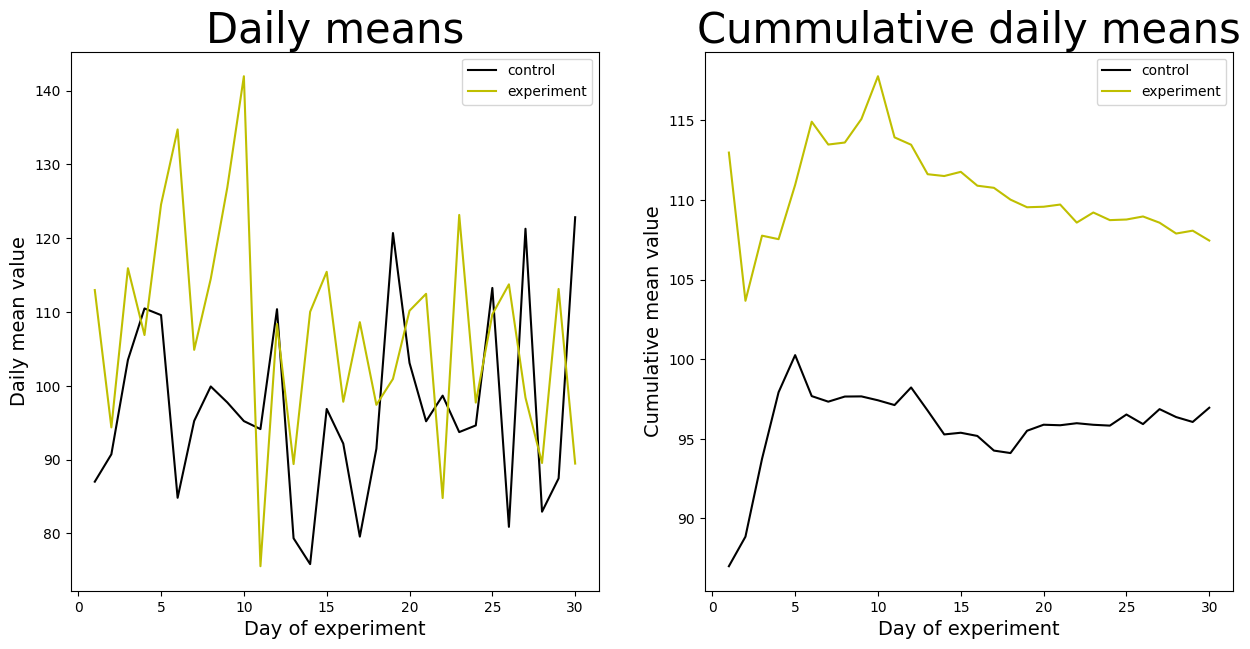

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,7))

# Заголовки графиков
axes[0].set_title('Daily means', size=30)
axes[1].set_title('Cummulative daily means', size=30)

# Подписи осей
axes[0].set_xlabel("Day of experiment", size=14)
axes[0].set_ylabel("Daily mean value", size=14)

axes[1].set_xlabel("Day of experiment", size=14)
axes[1].set_ylabel("Cumulative mean value", size=14)

# График ежедневных средних
axes[0].plot(days, daily_mean1, color='k', label='control')
axes[0].plot(days, daily_mean2, color='y', label='experiment')
axes[0].legend()

# График накопленных средних
axes[1].plot(days, cummulative_daily_mean1, color='k', label='control')
axes[1].plot(days, cummulative_daily_mean2, color='y', label='experiment')
axes[1].legend()

plt.show()

Daily means: по дневным средним нельзя сразу сказать, есть ли разница между группами.

Cummulative daily means: на кумулятивных средних видно, что экспериментальная группа действительно имеет более высокие значения метрики (примерно на 10–15% выше).

Как мы видим, ежедневные данные прыгают и явным образом не видно, что метрика в экспериментальной группе лучше метрики в контрольной

Чтобы нагляднее увидеть разницу между группами, строят график относительного различия, часто строят график относительного различия
  
$diff = \dfrac{cummulativeA}{cummulativeB} - 1$

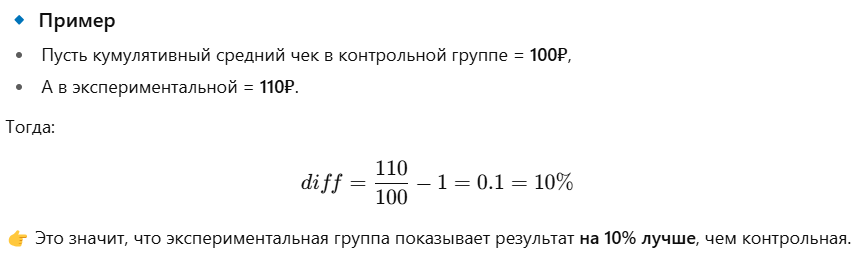

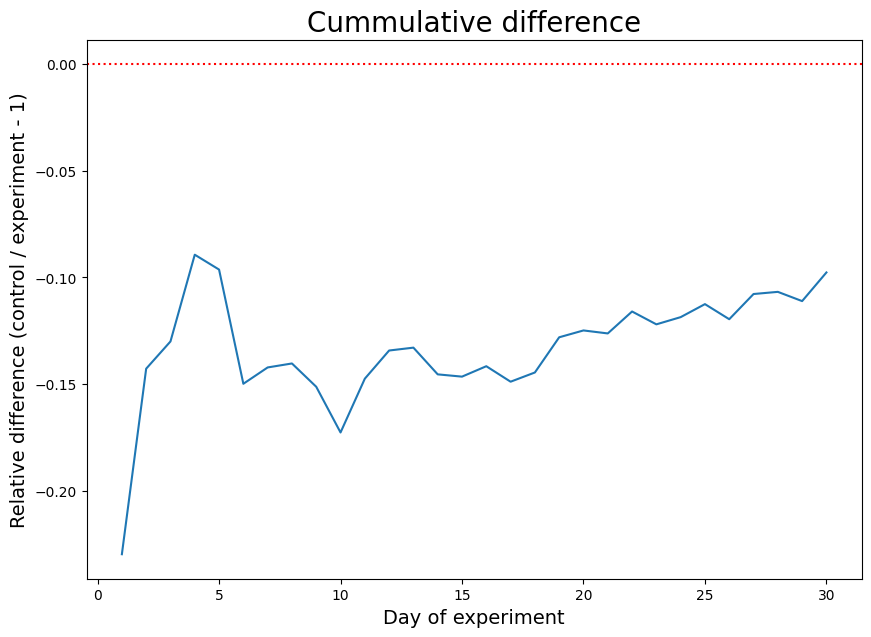

In [ ]:
diff = (np.array(cummulative_daily_mean1)/np.array(cummulative_daily_mean2)) - 1

plt.figure(figsize=(10,7))

plt.plot(days, diff)
plt.axhline(0, linestyle=':', color='r')

plt.title('Cummulative difference', size=20)
plt.xlabel("Day of experiment", size=14)
plt.ylabel("Relative difference (control / experiment - 1)", size=14)

plt.show()

- Красная пунктирная линия на уровне 0 — это точка, где контроль и эксперимент равны.

- Синяя линия показывает, насколько контроль отличается от эксперимента.

Отрицательные значения на графике = эксперимент лучше, чем контроль.
То, что линия «не доходит» до красной линии (0), нормально — значит, у групп действительно есть разница.

Линия уходит ниже 0 (до −0.1).

Это означает, что у экспериментальной группы среднее значение оказывается выше, чем у контрольной.

#### Анализ выбросов и всплесков

Зачастую, в реальных задачах, есть выбросы, аномально большие/маленькие значения:
1. Они безусловно возможны, но редки.  
2. Они могут сильно повлиять и исказить поиск нашего ответа на вопрос есть ли различия в среднем чеке, например
3. Их лучше убирать
4. Как правило исследователь сам решает, что считать выбросом(99%, 95%)

#### Peeking Problem(Проблема подглядывания)

Проблема подглядывания возникает, когда исследователь слишком часто смотрит на результаты теста до его завершения и принимает решение «раньше времени».

Мы решили подводить итоги на уровне значимости 5% каждый день (или просто больше одного раза за время теста).  

- Мы каждый день считаем p-value между группами (контроль и эксперимент).

- Если p-value < 0.05, мы говорим «есть статистически значимое различие» и можем «остановить» эксперимент.

- Но! Поскольку это A/A-тест (контроль и эксперимент сгенерированы из одного распределения, среднее = 100), на самом деле различий нет.

In [ ]:
days = np.arange(1, 61, 1)   # эксперимент идёт 60 дней

total_control = np.array([])      # накопленные данные для контроля
total_experiment = np.array([])   # накопленные данные для эксперимента

daily_mean1 = []   # средние по дням для контроля
daily_mean2 = []   # средние по дням для эксперимента
p_values = []      # список для хранения p-value

for day in days:
    # каждый день добавляем новые наблюдения
    control = np.random.normal(100, 60, size=10)      # контрольная группа (среднее=100 (Стандартное отклонение), σ=60, 10 юзеров)
    experiment = np.random.normal(100, 60, size=10)   # экспериментальная группа (среднее=100 (Стандартное отклонение), σ=60, 10 юзеров)

    total_control = np.append(total_control, control)         # накапливаем данные контроля
    total_experiment = np.append(total_experiment, experiment) # накапливаем данные эксперимента

    daily_mean1.append(control.mean())        #ежедневные средние
    daily_mean2.append(experiment.mean())

    cummulative_daily_mean1.append(total_control.mean())  # кумулятивное среднее для контроля
    cummulative_daily_mean2.append(total_experiment.mean()) # кумулятивное среднее для эксперимента

    # сравниваем накопленные данные t-тестом
    _, p_value = ttest_ind(total_control, total_experiment)
    p_values.append(p_value)  # сохраняем p-value за каждый день


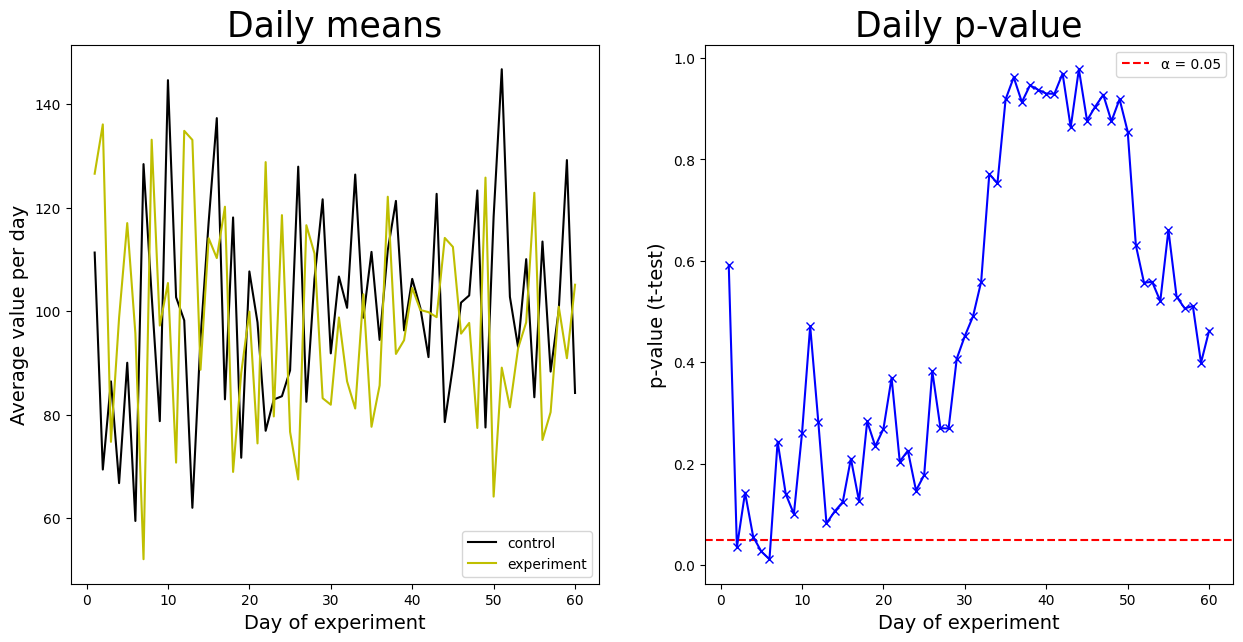

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,7))

# --- Левый график: средние значения ---
axes[0].set_title('Daily means', size=25)
axes[0].plot(days, daily_mean1, color='k', label='control')
axes[0].plot(days, daily_mean2, color='y', label='experiment')
axes[0].set_xlabel('Day of experiment', size=14)
axes[0].set_ylabel('Average value per day', size=14)
axes[0].legend()

# --- Правый график: p-value ---
axes[1].set_title('Daily p-value', size=25)
axes[1].axhline(0.05, ls='--', color='red', label='α = 0.05')
axes[1].plot(days, p_values, color='b', marker='x')
axes[1].set_xlabel('Day of experiment', size=14)
axes[1].set_ylabel('p-value (t-test)', size=14)
axes[1].legend()

plt.show()

- Daily means

чёрная линия = контрольная группа,

жёлтая = экспериментальная группа.

Они колеблются вокруг одного и того же среднего (100), потому что это A/A-тест (нет реальной разницы).

- Daily p-value

синяя линия = p-value, рассчитанное t-тестом каждый день.

красная пунктирная линия = уровень значимости 0.05.

Вывод:

🔹 Видно, что p-value скачет: то ближе к 1, то падает ниже 0.05.

🔹 На 5–10 дне оно даже пересекло порог значимости (красная линия).

🔹 Если бы мы принимали решение «тест успешен» в этот момент → мы бы ошиблись, потому что на самом деле различий нет (группы одинаковые).

Что это демонстрирует:

Это и есть Peeking Problem:

🔹если «подглядывать» и проверять p-value каждый день, то вероятность случайного нахождения значимости становится гораздо выше 5%.

🔹 то есть риск ложноположительных выводов сильно возрастает.

### Расчет необходимого количества элементов выборки

Есть много калькуляторов.

* https://abtestguide.com/calc/
* https://mindbox.ru/tools/ab-test-calculator/
* https://yandex.ru/adv/statvalue

Продвинутая формула:
    
$n > \dfrac{\left[ \left( z_{(1-\frac{\alpha}{2})} + z_{(1-\beta)} \right) \right]^2 \cdot \left(\sigma_{A}^2 + \sigma_{B}^2 \right)}{\bigtriangleup^2}$

$z_{(1-\frac{\alpha}{2})}$ - квантиль уровня $1-\frac{\alpha}{2}$  
$z_{(1-\beta)}$ - квантиль уровня ${(1-\beta)}$  
$\sigma_{A}^2$ - дисперсия группы $A$  
$\sigma_{B}^2$ - дисперсия группы $B$  
$\bigtriangleup$ - Minimal Detect Effect(Минимальный детектируемый эффект)

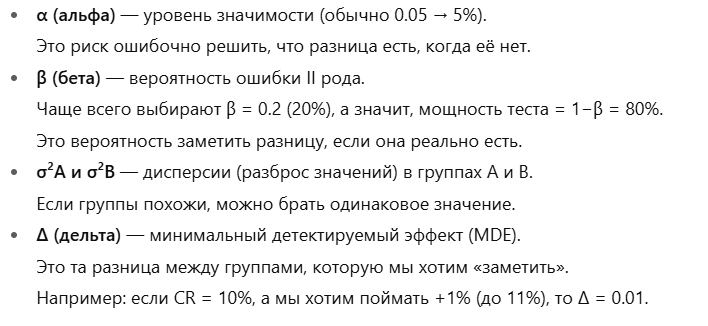

**Алгоритм**

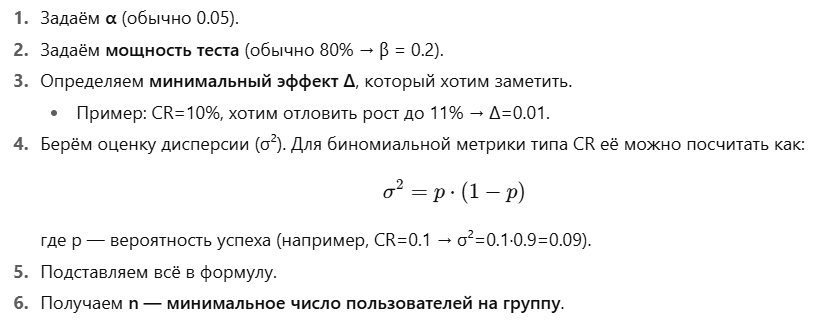

**Пример**

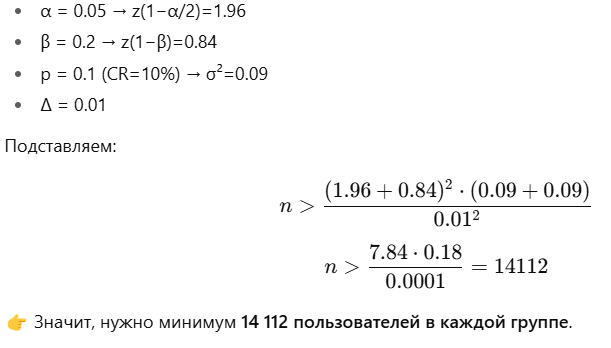